In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from utilities import *
from imbalance_gain import *
import pickle

In [2]:
# Parameters
omega1 = omega2 = 1
epsilon = 1
a = 0.2
b = 0.2
c = 5.7

# Coupled system
def coupled_system(x1, x2, x3, y1, y2, y3, omega1, omega2, epsilon):
    # x system
    dx1dt = -omega1 * x2 - x3
    dx2dt = omega1 * x1 + a * x2
    dx3dt = b + x3 * (x1 - c)
    
    # y system
    dy1dt = -omega2 * y2 - y3 + epsilon * (x1 - y1)
    dy2dt = omega2 * y1 + a * y2
    dy3dt = b + y3 * (y1 - c)
    
    return np.array([dx1dt, dx2dt, dx3dt, dy1dt, dy2dt, dy3dt])

# Runge-Kutta 4th order method
def rk4_step(func, r, t, h, *args):
    k1 = h * func(*r, *args)
    k2 = h * func(*(r + 0.5 * k1), *args)
    k3 = h * func(*(r + 0.5 * k2), *args)
    k4 = h * func(*(r + k3), *args)
    return r + (k1 + 2 * k2 + 2 * k3 + k4) / 6

In [3]:
# Time parameters
t0 = 0
t_end = 4000
dt = 0.01

# Initial values
x1_0, x2_0, x3_0 = 0.01, 0, 0
y1_0, y2_0, y3_0 = 0, 0, 0

# Time and state vectors
time = np.arange(t0, t_end, dt)
num_steps = len(time)
states = np.zeros((num_steps, 6))

# Set initial state
states[0] = [x1_0, x2_0, x3_0, y1_0, y2_0, y3_0]

# Main RK4 loop to generate the trajectory
for i in range(1, num_steps):
    states[i] = rk4_step(coupled_system, states[i-1], time[i-1], dt, omega1, omega2, epsilon)


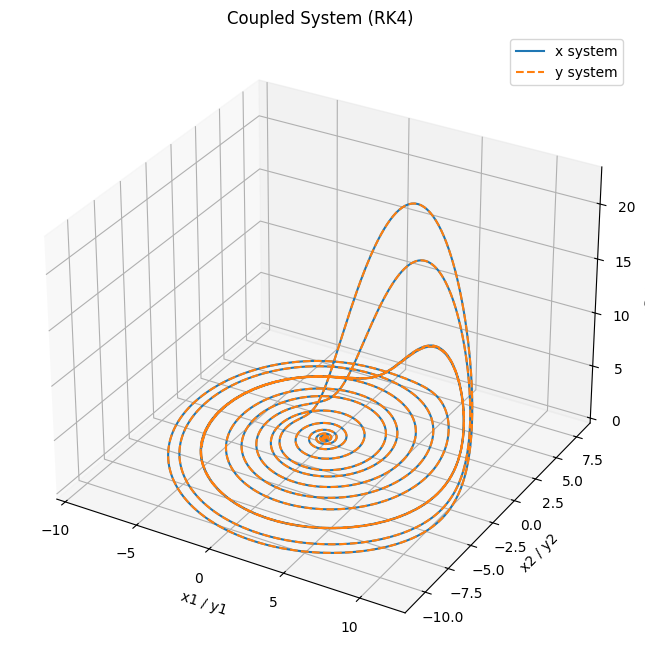

In [4]:
# Plotting results
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot(states[0:10000, 0], states[0:10000, 1], states[0:10000, 2], label='x system')
ax.plot(states[0:10000, 3], states[0:10000, 4], states[0:10000, 5], label='y system', linestyle='--')
ax.set_title('Coupled System (RK4)')
ax.set_xlabel('x1 / y1')
ax.set_ylabel('x2 / y2')
ax.set_zlabel('x3 / y3')
ax.legend()
plt.show()

In [5]:
tau = 20
N = 2500
traj_length = 200000
sample_times = np.linspace(50000,traj_length-tau-1,N,dtype=int)
k = 5
alphas = np.linspace(0,1,50)
n_jobs = 4 #parallelize the calculation for different alphas

In [6]:
X0 = states[sample_times,1:4]
Y0 = states[sample_times,4:]
rank_matrix_Xtau = compute_rank_matrix(states[sample_times + tau,1:4])
rank_matrix_Ytau = compute_rank_matrix(states[sample_times + tau,4:])

info_imbalances_X_to_Y = scan_alphas(cause_present=X0, effect_present=Y0, rank_matrix_effect_future=rank_matrix_Ytau, alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")
info_imbalances_Y_to_X = scan_alphas(cause_present=Y0, effect_present=X0, rank_matrix_effect_future=rank_matrix_Xtau, alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")

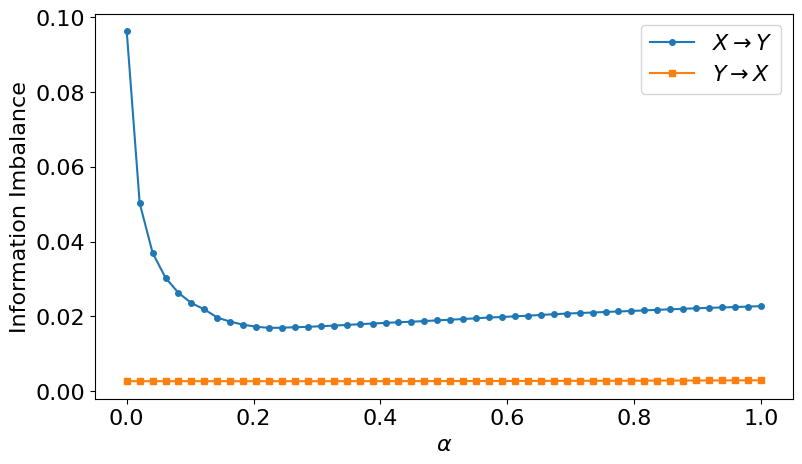

In [7]:
plt.rcParams['font.size'] = 16

plt.figure(figsize=(9,5))
plt.plot(alphas, info_imbalances_X_to_Y, 'o-', markersize=4, label="$X\\rightarrow Y$")
plt.plot(alphas, info_imbalances_Y_to_X, 's-', markersize=4, label="$Y\\rightarrow X$")
plt.xlabel("$\\alpha$")
plt.ylabel("Information Imbalance")
plt.legend()
plt.show()

In [8]:
imbalance_gain_X_to_Y, index_optimal_alpha_X_to_Y = compute_imbalance_gain(info_imbalances_X_to_Y)
imbalance_gain_Y_to_X, index_optimal_alpha_Y_to_X = compute_imbalance_gain(info_imbalances_Y_to_X)

print("Imbalance Gain X -> Y: {:.2f} %".format(100*imbalance_gain_X_to_Y))
print("Imbalance Gain Y -> X: {:.2f} %".format(100*imbalance_gain_Y_to_X))

print("Optimal alpha X -> Y: {:.2f}".format(alphas[index_optimal_alpha_X_to_Y]))
print("Optimal alpha Y -> X: {:.2f}".format(alphas[index_optimal_alpha_Y_to_X]))

Imbalance Gain X -> Y: 82.40 %
Imbalance Gain Y -> X: 0.21 %
Optimal alpha X -> Y: 0.22
Optimal alpha Y -> X: 0.29
